<a href="https://colab.research.google.com/github/Shreya-259/Cyberbullying-detection-on-social-networks-using-Machine-Learning-algorithms/blob/main/cyberbullying_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install Kaggle
!pip install -q Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyakuntala","key":"6b16873549875450404f8a677b84dfaf"}'}

In [3]:
#create a kaggle folder
! mkdir ~/.kaggle

In [4]:
#copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

In [5]:
# Permission for json to act
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle kernels pull ammishtandon/cyberbullying-detection

Source code downloaded to /content/cyberbullying-detection.ipynb


In [7]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [10]:
# import datasets
df = pd.read_csv('/content/cyberbullying_tweets.csv.zip')

In [11]:
!unzip cyberbullying_tweets.csv.zip

Archive:  cyberbullying_tweets.csv.zip
  inflating: cyberbullying_tweets.csv  


In [12]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [14]:
!pip install demoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.8 MB/s eta 0:00:00


** DATA PREPROCESSING **


In [15]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import demoji
import string

In [16]:
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


In [18]:
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm',
                  'im', 'll', 'y', 've', 'u', 'ur', 'don',
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat',
                  'de', 're', 'amp', 'will', 'wa', 'e', 'like'])
stemmer = SnowballStemmer('english')
def clean_text(text):

    # Remove Hashtag, Mention, URLs
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', text)
    text = " ".join(text.split())

    # Make all text lowercase
    text = text.lower()

    # Stemming
    text = " ".join([stemmer.stem(word) for word in text.split()])

    # Removing Punctuations
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)

    # Removing stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

    # Taking care of emojis
    emoji = demoji.findall(text)
    for emot in emoji:
        text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
df['cleaned_text'] = df['tweet_text'].apply(lambda text: clean_text(text))  # Applying the cleaning to the text data

In [20]:
df.head()

,tweet_text,cyberbullying_type,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,whi white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,gio meh thank head concern anoth angri dude tw...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account islam lies


In [21]:
df.isnull().sum()  # Checking for missing values

,0
tweet_text,0
cyberbullying_type,0
cleaned_text,0


In [22]:
df['cleaned_text'].duplicated().sum() # Checking for duplicate values

np.int64(2887)

In [23]:
df.drop_duplicates("cleaned_text", inplace = True)

In [24]:
df['cleaned_text'].str.isspace().sum()     # Checking for tweets with only whitespaces

np.int64(0)

In [25]:
df = df[df["cyberbullying_type"]!="other_cyberbullying"]

In [26]:
df['cyberbullying_type'].value_counts()

,count
cyberbullying_type,
religion,7946
age,7887
ethnicity,7797
not_cyberbullying,7670
gender,7637


<Axes: xlabel='cyberbullying_type', ylabel='count'>

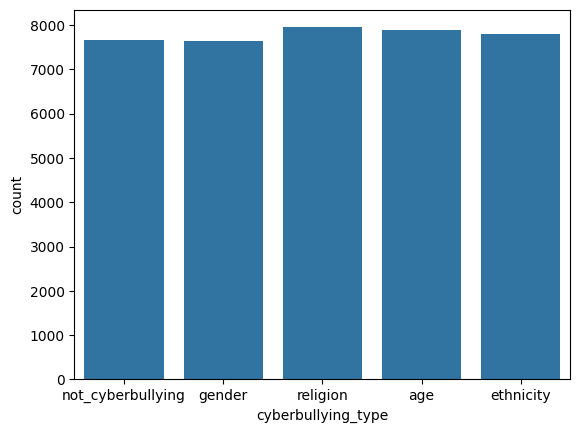

In [27]:
sns.countplot(data = df, x = 'cyberbullying_type')

In [28]:
# Plotting the top 15 words of each cyberbullying type
for cyber_type in df.cyberbullying_type.unique():

    top50_word = df.cleaned_text[df.cyberbullying_type==cyber_type].str.split(expand=True).stack().value_counts()[:15]

    fig = px.bar(top50_word, color=top50_word.values, color_continuous_scale=px.colors.sequential.RdPu, custom_data=[top50_word.values])
    fig.update_traces(marker_color='red')
    fig.update_traces(hovertemplate='<b>Count: </b>%{customdata[0]}')
    fig.update_layout(title=f"Top 15 words for {cyber_type}",
                     template='simple_white',
                     hovermode='x unified')
    fig.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['cleaned_text']  # Feature (raw data)
y = df['cyberbullying_type']  # Target Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
# Performing the train|test split. This test set is essentially a hold out test set as we'll be performing Cross Validation
# using Grid Search which will split our training data into a training and validation split

tfidf = TfidfVectorizer(max_features = 5000)  # Using the TF - IDF Vectorizer to extract top 5000 most important features
# from the text data

# Feature Extraction
X_train_tfidf = tfidf.fit_transform(X_train)  # Creating the vocabulary only from the training set to avoid data leakage from
X_test_tfidf = tfidf.transform(X_test)        # the test set.

X_train_tfidf  # Sparse Matrix is created to save memory since many values are close to 0

X_test_tfidf  # Sparse Matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 44207 stored elements and shape (3894, 5000)>

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tfidf_array_train = X_train_tfidf.toarray()   # Converting the sparse matrix to a numpy array (dense matrix)
tfidf_array_test = X_test_tfidf.toarray()     # Converting the sparse matrix to a numpy array (dense matrix)
scaled_X_train = scaler.fit_transform(tfidf_array_train)  # Fitting on only training data to avoid data leakage from test data
scaled_X_test = scaler.transform(tfidf_array_test) # and then tranforming both training and testing data


In [31]:
# Performing Dimensionality Reduction using Principal Component Analysis
from sklearn.decomposition import PCA
NUM_COMPONENTS = 5000  # Total number of features
pca = PCA(NUM_COMPONENTS)
reduced = pca.fit(scaled_X_train)

variance_explained = np.cumsum(pca.explained_variance_ratio_)  # Calculating the cumulative explained variance by the components

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(NUM_COMPONENTS),variance_explained, color='r')
ax.grid(True)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")

final_pca = PCA(0.9)
reduced_90 = final_pca.fit_transform(scaled_X_train) # Number of Components explaining 90% variance in the training data

reduced_90_test = final_pca.transform(scaled_X_test)

reduced_90.shape



final_pca = PCA(0.8)
reduced_80 = final_pca.fit_transform(scaled_X_train) # Number of Components explaining 80% variance in the training data

reduced_80.shape




** MODEL TRAINING **


In [32]:
! pip install confusion_matrix

from sklearn.metrics import confusion_matrix, classification_report

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.2 MB/s eta 0:00:00
  Created wheel for confusion_matrix: filename=confusion_matrix-0.1-py3-none-any.whl size=2400 sha256=a5b632fc4c97a34179651f7db69ac97960f9a378f58f9dcf8bd6bfcffc2ff12a
  Stored in directory: /root/.cache/pip/wheels/9d/47/b2/964238fce49c364ccd186baff5547de6410458a3efc69b937a
Successfully built confusion_matrix


In [ ]:
# NAIVE - BAYES
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred = nb_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)
labels = ['age', 'ethnicity', 'gender', 'not_cyberbullying','religion']
preds_nb_model = nb_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_nb_model))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

pip install optuna

from sklearn.svm import LinearSVC
from sklearn.experimental import enable_halving_search_cv  # Import the enable_halving_search_cv module
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

svm_model = LinearSVC()
C = [1e-5, 1e-4, 1e-2, 1e-1, 1]
param_grid = {'C': C}
grid_svm_model = HalvingGridSearchCV(svm_model, param_grid=param_grid, n_jobs=-1, min_resources='exhaust', factor=3)
grid_svm_model.fit(X_train_tfidf, y_train)
preds_grid_svm_model = grid_svm_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_svm_model))
confusion_matrix_result = confusion_matrix(y_test, preds_grid_svm_model)
labels = ['age', 'ethnicity', 'gender', 'not_cyberbullying', 'religion']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.show()

grid_svm_model.best_estimator_

In [ ]:
# RANDOM FORESTS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Create a random forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [64, 100, 128],
    'bootstrap': [True, False]
}

# Create the GridSearchCV object
grid_rf_model = GridSearchCV(rf_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1)

# Fit the model on the training data
grid_rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
preds_grid_rf_model = grid_rf_model.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, preds_grid_rf_model))
confusion_matrix_result = confusion_matrix(y_test, preds_grid_rf_model)
print(confusion_matrix_result)
labels = ['age', 'ethnicity', 'gender', 'not_cyberbullying','religion']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.show()

grid_rf_model.best_estimator_


In [ ]:
#GRADIENT BOOSTING
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

grad_model = GradientBoostingClassifier(random_state=42)
param_grid = {'n_estimators': [64, 100, 128, 200]}
grid_grad_model = HalvingGridSearchCV(grad_model, param_grid=param_grid, n_jobs=-1, min_resources='exhaust', factor=3)
grid_grad_model.fit(X_train_tfidf, y_train)
preds_grid_grad_model = grid_grad_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_grad_model))
confusion_matrix_result = confusion_matrix(y_test, preds_grid_grad_model)
print(confusion_matrix_result)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
tick_marks = range(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.show()

grid_grad_model.best_estimator_


In [ ]:
#NEURAL NETWORKS
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

nn_model = MLPClassifier(activation='logistic', max_iter=10)  # Sigmoid Activation Function
param_grid = {'learning_rate_init': [0.001, 0.0015, 0.002, 0.0025]}
grid_nn_model = HalvingGridSearchCV(nn_model, param_grid=param_grid, n_jobs=-1, min_resources='exhaust', factor=3)
grid_nn_model.fit(X_train_tfidf, y_train)
preds_grid_nn_model = grid_nn_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_nn_model))
confusion_matrix_result = confusion_matrix(y_test, preds_grid_nn_model)
print(confusion_matrix_result)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
tick_marks = range(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.show()

grid_nn_model.best_estimator_

"""Hence, Random forest turns out to be the best classifier.


** PIPELINE CREATION **

In [33]:
pipe.predict(["@abc shut up gay boy"])# Creating a pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('tfidf', TfidfVectorizer(max_features = 5000)), ('rf_model', RandomForestClassifier(n_estimators = 128, random_state = 42))])
pipe.fit(X, y)

pipe.predict(["@abc Hey man! Great match today. Your smashes were spot on. Let's continue playing together. \
               #badminton #brotherhood #men #doubles"])

pipe.predict(["Going to Africa. Hope I don't get AIDS. Just kidding. I'm white!"])

pipe.predict(["Muslims should be punished. We are not doing enough to rid us of those filthy animals."])

pipe.predict(["@abc Man you don't have any facial hair. You look like a fucking 9 year old school boy! #clown #idiot"])

NameError: name 'pipe' is not defined